In [49]:
import tensorflow as tf

In [50]:
# verify tensorflow 1.15
tf.__version__

'1.15.0'

In [51]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [52]:
import numpy as np
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Lambda, Conv1D, maximum, GlobalMaxPooling1D, Dense, GaussianNoise, MaxPooling1D, Flatten, BatchNormalization, SpatialDropout1D
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import non_neg
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from  tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence

import matplotlib.pyplot as plt
import pandas as pd
import logomaker

import random
from tqdm import trange
from subprocess import Popen, PIPE, run
import sys
import pickle
from pyfaidx import Fasta
import random
import glob
import bioframe
import os
import tqdm
from multiprocessing import Pool
from sklearn.metrics import roc_auc_score

In [53]:
def getFasta(bf, genomeFasta):
    genome = Fasta(genomeFasta, as_raw=True, sequence_always_upper=True)
    if "strand" in  bf:
        bf.loc[:, "seq"] = [genome[chrom][start:end] if strand == "+" else get_rc(genome[chrom][start:end]) for chrom, start, end, strand in zip(bf.chrom, bf.start, bf.end, bf.strand)]
    else:
        bf.loc[:,"seq"] = [genome[chrom][start:end] for chrom, start, end in zip(bf.chrom, bf.start, bf.end)]
    return(bf)

def load_peaks(peaks, l=None):
    data = pd.read_csv(peaks, header=0, sep="\t", skipfooter=1, engine="python")
    data = data.rename(columns = {"#CHROM" : "chrom", 
                                  "START" : "start", 
                                  "END" : "end", 
                                  "fold_enrichment" : "signal",
                                  " supporting_peakcallers" : "peak_callers"})
    data["n_peak_callers"] = data.peak_callers.str.count(",") + 1
    if l is not None:
        w2 = l // 2
        data["start"] = data["abs_summit"] - w2
        data["end"] = data["abs_summit"] + w2
    return(data)

def merge_peaks(peaks_dfs, l=200):
    w2 = l // 2
    toReturn = peaks_dfs[0].copy()
    for i in range(1, len(peaks_dfs)):
        toReturn = bioframe.closest(toReturn, peaks_dfs[i], 
                               suffixes=('_1','_2'))
        toReturn = toReturn[toReturn["distance"] == 0]
        toReturn["abs_summit_1"] = (i * toReturn["abs_summit_1"] + toReturn["abs_summit_2"]) // (i+1)
        toReturn["signal_1"] = (i * toReturn["signal_1"] + toReturn["signal_2"]) / (i+1)
        toReturn = toReturn.rename(columns = {"chrom_1" : "chrom", 
                                              "start_1" : "start", 
                                              "end_1" : "end", 
                                              "signal_1" : "signal",
                                              "abs_summit_1" : "abs_summit"})
    toReturn["start"] = toReturn["abs_summit"] - w2
    toReturn["end"] = toReturn["abs_summit"] + w2
    
    return(toReturn)



def get_data(TF, assay, data_dir, peaks="all", l=300):
    if assay == "CHS":
        dataFiles = glob.glob(data_dir + assay + "/" + TF + "/*" )
        CHS_data = [load_peaks(_, l) for _ in dataFiles]
        if peaks == "shared" and len(CHS_data) > 1:
            print("Merging peaks")
            CHS_data = merge_peaks(CHS_data, l=l)
        else:
            CHS_data = pd.concat(CHS_data)

        data = CHS_data[["chrom", "start", "end", "abs_summit", "signal"]]
    else:
        GHTS = glob.glob(data_dir + "GHTS" + "/" + TF + "/*" )
        cycles = sorted([os.path.basename(_).split(".")[-2] for _ in GHTS])
        max_cycle = cycles[-1]
        print("Last cycle: {}".format(max_cycle))
        GHTS = [_ for _ in GHTS if "." + max_cycle + "." in _]
        GHTS_data = [load_peaks(_, l) for _ in GHTS]
        # if peaks == "shared":
        #     GHTS_data = merge_peaks(GHTS_data, l=l)
        # else:
        GHTS_data = pd.concat(GHTS_data)
        data = GHTS_data[["chrom", "start", "end", "abs_summit", "signal"]]
    
    data = data.sort_values(['chrom', 'start'], ascending=[True, True]).reset_index(drop=True)
    data = getFasta(data, genomeFasta)
    return(data)


In [54]:
# altschulEriksonDinuclShuffle.py
# P. Clote, Oct 2003

def computeCountAndLists(s):

    #Initialize lists and mono- and dinucleotide dictionaries
    List = {} #List is a dictionary of lists
    List['A'] = []; List['C'] = [];
    List['G'] = []; List['T'] = [];
    # FIXME: is this ok?
    List['N'] = []
    nuclList   = ["A","C","G","T","N"]
    s       = s.upper()
    #s       = s.replace("U","T")
    nuclCnt    = {}  #empty dictionary
    dinuclCnt  = {}  #empty dictionary
    for x in nuclList:
        nuclCnt[x]=0
        dinuclCnt[x]={}
        for y in nuclList:
            dinuclCnt[x][y]=0

    #Compute count and lists
    nuclCnt[s[0]] = 1
    nuclTotal     = 1
    dinuclTotal   = 0
    for i in range(len(s)-1):
        x = s[i]; y = s[i+1]
        List[x].append( y )
        nuclCnt[y] += 1; nuclTotal  += 1
        dinuclCnt[x][y] += 1; dinuclTotal += 1
    assert (nuclTotal==len(s))
    assert (dinuclTotal==len(s)-1)
    return nuclCnt,dinuclCnt,List


def chooseEdge(x,dinuclCnt):
    z = random.random()
    denom=dinuclCnt[x]['A']+dinuclCnt[x]['C']+dinuclCnt[x]['G']+dinuclCnt[x]['T']+dinuclCnt[x]['N']
    numerator = dinuclCnt[x]['A']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['A'] -= 1
        return 'A'
    numerator += dinuclCnt[x]['C']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['C'] -= 1
        return 'C'
    numerator += dinuclCnt[x]['G']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['G'] -= 1
        return 'G'
    numerator += dinuclCnt[x]['T']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['T'] -= 1
        return 'T'
    dinuclCnt[x]['N'] -= 1
    return 'N'

def connectedToLast(edgeList,nuclList,lastCh):
    D = {}
    for x in nuclList: D[x]=0
    for edge in edgeList:
        a = edge[0]; b = edge[1]
        if b==lastCh: D[a]=1
    for i in range(3):
        for edge in edgeList:
            a = edge[0]; b = edge[1]
            if D[b]==1: D[a]=1
    ok = 0
    for x in nuclList:
        if x!=lastCh and D[x]==0: return 0
    return 1

def eulerian(s):
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)
    #compute nucleotides appearing in s
    nuclList = []
    for x in ["A","C","G","T","N"]:
        if x in s: nuclList.append(x)
    #create dinucleotide shuffle L
    firstCh = s[0]  #start with first letter of s
    lastCh  = s[-1]
    edgeList = []
    for x in nuclList:
        if x!= lastCh: edgeList.append( [x,chooseEdge(x,dinuclCnt)] )
    ok = connectedToLast(edgeList,nuclList,lastCh)
    return ok,edgeList,nuclList,lastCh


def shuffleEdgeList(L):
    n = len(L); barrier = n
    for i in range(n-1):
        z = int(random.random() * barrier)
        tmp = L[z]
        L[z]= L[barrier-1]
        L[barrier-1] = tmp
        barrier -= 1
    return L

def dinuclShuffle(s):
    ok = 0
    while not ok:
        ok,edgeList,nuclList,lastCh = eulerian(s)
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)

    #remove last edges from each vertex list, shuffle, then add back
    #the removed edges at end of vertex lists.
    for [x,y] in edgeList: List[x].remove(y)
    for x in nuclList: shuffleEdgeList(List[x])
    for [x,y] in edgeList: List[x].append(y)

    #construct the eulerian path
    L = [s[0]]; prevCh = s[0]
    for i in range(len(s)-2):
        ch = List[prevCh][0]
        L.append( ch )
        del List[prevCh][0]
        prevCh = ch
    L.append(s[-1])
    #t = string.join(L,"")
    t = "".join(L)
    return t

def get_rc(re):
    """
    Return the reverse complement of a DNA/RNA RE.
    """
    return re.translate(str.maketrans('ACGTURYKMBVDHSWN', 'TGCAAYRMKVBHDSWN'))[::-1]



# enriched kmer finding code from https://github.com/daquang/YAMDA
def count_seqs_with_words(seqs, halflength, ming, maxg, alpha, revcomp, desc):
    if alpha == 'protein':
        ambiguous_character = 'X'
    else:
        ambiguous_character = 'N'
    gapped_kmer_dict = {}  # each key is the gapped k-mer word
    for g in trange(ming, maxg + 1, 1, desc=desc):
        w = g+2*halflength # length of the word
        gap = g * ambiguous_character
        for seq in seqs:
            slen = len(seq)
            for i in range(0, slen-w+1):
                word = seq[i : i+w]
                # skip word if it contains an ambiguous character
                if ambiguous_character in word:
                    continue
                # convert word to a gapped word. Only the first and last half-length letters are preserved
                word = word[0:halflength] + gap + word[-halflength:]
                update_gapped_kmer_dict(gapped_kmer_dict, word, revcomp)
    return gapped_kmer_dict


def update_gapped_kmer_dict(gapped_kmer_dict, word, revcomp):
    # use the lower alphabet word for rc
    if revcomp:
        word = min(word, get_rc(word))
    if word in gapped_kmer_dict:  # word has been encountered before, add 1
        gapped_kmer_dict[word] += 1
    else:  # word has not been encountered before, create new key
        gapped_kmer_dict[word] = 1


def get_zscores(pos_seq_counts, neg_seq_counts):
    zscores_dict = {}
    for word in pos_seq_counts:
        p = pos_seq_counts[word]
        if word in neg_seq_counts:
            n = neg_seq_counts[word]
        else:
            n = 1
        zscore = 1.0*(p - n)/np.sqrt(n)
        zscores_dict[word] = zscore
    return zscores_dict


# returns the words in order, from largest to smallest, by z-scores
def sorted_zscore_keys(zscores_dict):
    sorted_keys = sorted(zscores_dict, key=zscores_dict.__getitem__, reverse=True)
    return sorted_keys


def find_n_top_words(zscores_dict, num_find):
    keys = np.array(list(zscores_dict.keys()))
    values = np.array(list(zscores_dict.values()))
    ind = np.argpartition(values, -num_find)[-num_find:]
    top_words = list(keys[ind])
    return top_words


def find_enriched_gapped_kmers(pos_seqs, neg_seqs, halflength, ming, maxg, alpha, revcomp, num_find):
    pos_seq_counts = count_seqs_with_words(pos_seqs, halflength, ming, maxg, alpha, revcomp,
                                           'Searching positive sequences')
    neg_seq_counts = count_seqs_with_words(neg_seqs, halflength, ming, maxg, alpha, revcomp,
                                           'Searching negative sequences')
    zscores = get_zscores(pos_seq_counts,neg_seq_counts)
    top_words = find_n_top_words(zscores, num_find)
    return top_words

DNA_SEQ_DICT = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1],
}

def encode_sequence(seq, N = [0, 0, 0, 0], seq_dict = None, useN = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    if useN == 'uniform':
        N = [(1/len(seq_dict)) for _ in seq_dict]
    elif useN == 'zeros':
        N = [0 for _ in seq_dict]
    d = { **seq_dict, 'N' : N }
    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')
 
def decode_sequence(encoded_seq, seq_dict = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    seq_list = encoded_seq.astype('int').tolist()
    def decode_base(encoded_base):
        for letter,onehot in seq_dict.items():
            if np.array_equal(encoded_base, onehot):
                return letter
        return "N"
    return "".join(decode_base(b) for b in encoded_seq.astype('int'))

def get_information_content(x):
    ic = x * np.log2((x + .001) / .25)
    if ic > 0:
        return(ic)
    else:
        return(0.0)

In [55]:
def shuffle_wrapper(seqs):
    with Pool(4) as p:
        negSeqs = p.map(dinuclShuffle, seqs)
    return(negSeqs)

class dataGen(Sequence):
    def __init__(self, data, 
                 batchSize = 32,
                 l = 300,
                 seqsPerEpoch=20000,
                 padBy = 0,
                 genomeFasta=None,
                 genomeSizes=None,
                 augment_by=0,
                 curriculum=False,
                 weight_seqs = False):
        
        self.data = data
        self.genomeFasta = genomeFasta
        self.genomeSizes = genomeSizes
        self.seqsPerEpoch = seqsPerEpoch
        self.nPosPerEpoch = seqsPerEpoch // 2
        self.nPos = self.data.shape[0]
        self.augment_by = augment_by
        self.curriculum = curriculum
        self.weight_seqs = weight_seqs
        self.l = l
        self.L = self.l +  2 * self.augment_by
        
        self.l2 = self.l // 2
        self.L2 = self.L // 2
        
        if self.nPos < self.nPosPerEpoch:
            self.posData = self.data.sample(n=self.nPosPerEpoch, replace=True).reset_index(drop=True)
        else:
            self.posData = self.data.copy(deep=True)
            
        if self.augment_by > 0:
            self.posData["aug_by"] = np.random.randint(-self.augment_by, self.augment_by, size=self.posData.shape[0])
            self.posData["posSeq"] = self.posData.apply(lambda x: x['seq'][(self.L2 -self.l2 + x["aug_by"]):(self.L2 +self.l2 + x["aug_by"])], axis=1)
        else:
            self.posData["posSeq"] = self.posData.apply(lambda x: x['seq'][(self.L2 -self.l2):(self.L2 +self.l2)], axis=1)
        self.posData["negSeq"] = shuffle_wrapper(self.posData.posSeq)
        
        if self.curriculum:
            print("Sorting sequences by signal")
            self.posData = self.posData.sort_values("signal", ascending=False).reset_index(drop=True)
        
        self.batchSize = batchSize
        self.b2 = self.batchSize // 2
        self.padBy = padBy
        self.labels = np.array([1 for i in range(self.b2)] + [0 for i in range(self.b2)])
        self.epoch = 0
        self.nIter = 0
        self.shuffleEvery = int(self.nPos // self.nPosPerEpoch) 
        
        if self.shuffleEvery == 0:
            self.shuffleEvery = 1

                
    def __len__(self):
        return(int(np.floor(self.seqsPerEpoch / self.batchSize)))

    
    def on_epoch_end(self):
        self.epoch += 1
        if (self.epoch % self.shuffleEvery) == 0:
            if self.nPos < self.nPosPerEpoch:
                self.posData = self.data.sample(n=self.nPosPerEpoch, replace=True, weights="signal").reset_index(drop=True)
            else:
                self.posData = self.data.copy(deep=True)
            
            if self.augment_by > 0:
                self.posData["aug_by"] = np.random.randint(-self.augment_by, self.augment_by, size=self.posData.shape[0])
                self.posData["posSeq"] = self.posData.apply(lambda x: x['seq'][(self.L2 -self.l2 + x["aug_by"]):(self.L2 +self.l2 + x["aug_by"])], axis=1)
            else:
                self.posData["posSeq"] = self.posData.apply(lambda x: x['seq'][(self.L2 -self.l2):(self.L2 +self.l2)], axis=1)
            
            if self.curriculum:
                self.posData = self.posData.sort_values("signal", ascending=False).reset_index(drop=True)
                
            self.posData["negSeq"] = shuffle_wrapper(self.posData.posSeq)
            self.nIter = 0

    def __getitem__(self, index):
        X = 0.25 * np.ones((self.batchSize, 2*self.padBy + self.l, 4))
        if self.weight_seqs:
            weights = np.zeros(self.batchSize)
            
        for i, (_, row) in enumerate(self.posData.iloc[(index*self.b2):((index*self.b2) + self.b2)].iterrows()):
            posSeq = row.posSeq
            negSeq = row.negSeq
            X[i,self.padBy:self.l+self.padBy,:] = encode_sequence(posSeq)
            X[i+self.b2,self.padBy:self.l+self.padBy,:] = encode_sequence(negSeq)
            
            if self.weight_seqs:
                weights[i] = np.log2(row.signal + 1)
                weights[i+self.b2] = 1
        if self.weight_seqs:
            return(X, self.labels, weights)
        else:
            return(X, self.labels)

In [56]:
from  tensorflow.keras.callbacks import Callback
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2,
                 shape="cosine"):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor
        
        self.shape = shape
        self.history = {}
        self.learning_rates = []

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        #print(fraction_to_restart)
        if self.shape == "cosine":
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        else:
            if fraction_to_restart < 0.5:
                lr = fraction_to_restart * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
            else:
                lr = (1 - fraction_to_restart) * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
        self.learning_rates.append(lr)
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        if self.shape == "cosine":
            K.set_value(self.model.optimizer.lr, self.max_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)
        
class SWA(Callback):

    def __init__(self, epochs_to_train, prop = 0.2, interval = 1):
        super(SWA, self).__init__()
        self.epochs_to_train = epochs_to_train
        self.prop = prop
        self.interval = interval
        self.n_models = 0
        self.epoch = 0
        
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        self.weights = []
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        if epoch % self.interval == 0:
            self.weights.append(self.model.get_weights())
            self.n_models += 1
        else:
            pass

    def on_train_end(self, logs=None):
        num_models_to_average = int(np.ceil(self.prop * self.epoch))
        new_weights = list()
        for weights_list_tuple in zip(*self.weights[-num_models_to_average:]): 
            new_weights.append(
                np.array([np.array(w).mean(axis=0) for w in zip(*weights_list_tuple)])
            )
        self.model.set_weights(new_weights)

In [57]:
def construct_model(num_kernels=32,
                    kernel_width=24,
                    seq_len=None,
                    dropout_prop=0.0,
                    use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.0001, seed=12),
                    optimizer='adam',
                    activation='linear',
                    num_classes=1,
                    l1_reg=0.0,
                    l2_reg= 0.0,
                    gaussian_noise = 0.0,
                    spatial_dropout = 0.0,
                    rc = True,
                    padding="same",
                    conv_name="shared_conv"):
        
    seq_input = Input(shape=(seq_len,4))
        
    # apply gaussian blurring
    if gaussian_noise > 0.0:
         noisy_seq = GaussianNoise(gaussian_noise)(seq_input)
    
    # apply spatial dropout
    if spatial_dropout > 0.0:
        sd = SpatialDropout1D(spatial_dropout)
        if gaussian_noise > 0.0:
            noisy_seq = sd(noisy_seq)
        else:
            noisy_seq = sd(seq_input)
        
    # perform reverse complement
    rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
    
    seq_rc = rc_op(seq_input)
    if gaussian_noise > 0.0 or spatial_dropout > 0.0:
        noisy_seq_rc = rc_op(noisy_seq)
    else:
        seq_rc = rc_op(seq_input)
        
    # convolution
    shared_conv = Conv1D(num_kernels, kernel_width,
                         strides=1,
                         padding=padding, 
                         activation=activation,
                         use_bias=use_bias,
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=regularizers.l1_l2(l1=l1_reg,
                                                               l2=l2_reg),
                         bias_initializer='zeros',
                         name=conv_name)
    if gaussian_noise > 0.0 or spatial_dropout > 0.0:
        conv_for = shared_conv(noisy_seq)
        conv_rc = shared_conv(noisy_seq_rc)
    else:
        conv_for = shared_conv(seq_input)
        conv_rc = shared_conv(seq_rc)

    merged = maximum([conv_for, conv_rc])
    pooled = GlobalMaxPooling1D()(merged)
    
    if dropout_prop > 0.0:
        dropout = Dropout(dropout_prop)(pooled)
        output = Dense(1, activation='sigmoid',
                   use_bias=True,
                   kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                   kernel_constraint=non_neg(), 
                   bias_initializer='zeros',
                   name="dense_1")(dropout)
    else:
        output = Dense(1, activation='sigmoid',
                       use_bias=True,
                       kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                       kernel_constraint=non_neg(), 
                       bias_initializer='zeros',
                       name="dense_1")(pooled)
    model = Model(inputs=seq_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model



def construct_scan_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'scan_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=False, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_seq = conv(seq)
    
    
    model = Model(inputs=seq, outputs=conv_seq)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer('scan_conv').set_weights([conv_weights])
    return model


In [58]:
data_dir = "../data/"
genomeFasta = "../data/hg38.fa"
output_dir = "../demo/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [59]:
# Parameters
TF = "GABPA"
assay = "CHS" # or GHTS
peaks = "shared" # or all
n_motifs = 1 # number of motifs / convolution kernels
epochs = 10 # number of epochs to train for
seqsPerEpoch = 5000
l = 300
w = 32
aug_by = 100
n_kmers = 4 # if greater than 0, will seed network with that many enriched kmers
if n_kmers > n_motifs:
    n_kmers = n_motifs
L = l + 2*aug_by
l2 = l // 2
L2 = L // 2
genome = Fasta(genomeFasta, as_raw=True, sequence_always_upper=True)
test_chroms = ["chr1"] # chromosomes to hold out
activation = "linear" # or exponential (convolution layer activation)
use_bias = True # include bias term in convolution layer
sd = 0.2 # spatial dropout
gaussian_noise = 0.1
l1 = 1e-5
l2 = 1e-5
curriculum = True
weight_seqs = False
min_lr = .001
max_lr = .1

In [60]:
# will throw a parser warning because the peak files have a header & footer that must be skipped
data = get_data(TF, assay, data_dir, l=L, 
                peaks=peaks)

In [61]:
data.head()

,chrom,start,end,abs_summit,signal,seq
0,chr1,827281,827781,827531,8.26088,ACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCTT...
1,chr1,941567,942067,941817,4.96305,CGGGGTCAGTCGGGAGGGGTCGGCCAGAGGACTCAGAGCTGGAGGC...
2,chr1,959036,959536,959286,31.48650,AAGCCCGAAGCTAGGAACTCGTCCACCGTCAGCTCCGCCAGGCGCC...
3,chr1,1019529,1020029,1019779,5.58398,GCGCCCGCCCCGGCACCGGGACCCGCCTCCGCGCCGCAGCTCCCGG...
4,chr1,1231843,1232343,1232093,5.56368,ACACTTGGCCCCGCGGCCTGCAGCGGCCGTCCCGGGCCCCTCACTC...


In [62]:
n = data.shape[0]
print("{} total sequences provided".format(n))

2288 total sequences provided


In [63]:
if n_kmers > 0:
    print("Finding enriched gapped kmers")
    if n > 5000:
        tmpPosSeqs = data.sort_values("signal", ascending=False).head(5000).seq.tolist()
        tmpPosSeqs = [seq[(L2-50):(L2+50)] for seq in tmpPosSeqs]
    else:
        tmpPosSeqs = data.seq.tolist()
        tmpPosSeqs = [seq[(L2-50):(L2+50)] for seq in tmpPosSeqs]
    kmers = find_enriched_gapped_kmers(tmpPosSeqs, [dinuclShuffle(_) for _ in tmpPosSeqs],  3, 0, 18, "dna", False, n_kmers)

Finding enriched gapped kmers


Searching negative sequences: 100%|██████████| 19/19 [00:02<00:00,  7.81it/s]


In [64]:
print("Enriched kmers...\n" + "\n".join(["\t" + _ for _ in kmers[::-1]]))

Enriched kmers...
	TTCCGG


In [65]:
train_data = data[~data["chrom"].isin(test_chroms)]
test_data = data[data["chrom"].isin(test_chroms)]

In [66]:
train_gen = dataGen(train_data, 
                 batchSize = 32,
                 l = l,
                 seqsPerEpoch=seqsPerEpoch,
                 padBy = w,
                 augment_by=aug_by, 
                    curriculum=curriculum, 
                    weight_seqs=weight_seqs)

test_gen = dataGen(train_data, 
                 batchSize = 32,
                 l = l,
                 seqsPerEpoch=1000,
                 padBy = w,
                 augment_by=0, 
                   curriculum=False, 
                   weight_seqs=False)

Sorting sequences by signal


In [67]:
model = construct_model(num_kernels=n_motifs,
                        kernel_width=w,
                        l1_reg=l1,
                        l2_reg=l2,
                        spatial_dropout=sd,
                        gaussian_noise=gaussian_noise,
                        activation=activation,
                        use_bias=use_bias,
                        padding="valid")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, None, 4)      0           input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, None, 4)      0           gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 4)      0           spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [68]:
if n_kmers > 0:
    if use_bias:
        conv_weights, conv_bias = model.get_layer("shared_conv").get_weights()
    else:
        conv_weights = model.get_layer("shared_conv").get_weights()[0]


    for i in range(n_kmers):
        kmer = kmers[i]
        l = len(kmer)
        conv_weights[((w - l)//2):(((w - l)//2)+l),:,i] = encode_sequence(kmer)


    if use_bias:
        model.get_layer("shared_conv").set_weights([conv_weights, conv_bias])
    else:
        model.get_layer("shared_conv").set_weights([conv_weights])


In [69]:
lr_decay = (min_lr / max_lr) ** (1 / epochs)
schedule = SGDRScheduler(min_lr=min_lr,
                             max_lr=max_lr,
                             steps_per_epoch=train_gen.__len__(),
                             lr_decay=lr_decay,
                             cycle_length=1,
                             mult_factor=1.0, 
                             shape="triangular")

swa = SWA(epochs)


In [70]:
history = model.fit(train_gen, 
                    steps_per_epoch = train_gen.__len__(), 
                    verbose=2, 
                    epochs=epochs,
                    workers=4,
                    callbacks = [schedule, swa],
                    validation_data = test_gen,
                    validation_steps = test_gen.__len__(), 
                    shuffle=False)


Epoch 1/10
Epoch 1/10
156/156 - 3s - loss: 0.6253 - acc: 0.6336 - val_loss: 0.5045 - val_acc: 0.7601
Epoch 2/10
Epoch 1/10
156/156 - 4s - loss: 0.5058 - acc: 0.7524 - val_loss: 0.4686 - val_acc: 0.7923
Epoch 3/10
Epoch 1/10
156/156 - 4s - loss: 0.4796 - acc: 0.7694 - val_loss: 0.4421 - val_acc: 0.8054
Epoch 4/10
Epoch 1/10
156/156 - 4s - loss: 0.4592 - acc: 0.7863 - val_loss: 0.4400 - val_acc: 0.8115
Epoch 5/10
Epoch 1/10
156/156 - 4s - loss: 0.4723 - acc: 0.7740 - val_loss: 0.4594 - val_acc: 0.7964
Epoch 6/10
Epoch 1/10
156/156 - 4s - loss: 0.4604 - acc: 0.7792 - val_loss: 0.4593 - val_acc: 0.7954
Epoch 7/10
Epoch 1/10
156/156 - 4s - loss: 0.4697 - acc: 0.7752 - val_loss: 0.4602 - val_acc: 0.7994
Epoch 8/10
Epoch 1/10
156/156 - 4s - loss: 0.4768 - acc: 0.7652 - val_loss: 0.4592 - val_acc: 0.7944
Epoch 9/10
Epoch 1/10
156/156 - 4s - loss: 0.4629 - acc: 0.7710 - val_loss: 0.4569 - val_acc: 0.7994
Epoch 10/10
Epoch 1/10
156/156 - 4s - loss: 0.4702 - acc: 0.7714 - val_loss: 0.4650 - val_a

In [71]:
model.save_weights(output_dir + "/weights.h5")

In [72]:
if use_bias:
    conv_weights, conv_bias = model.get_layer("shared_conv").get_weights()
else:
    conv_weights = model.get_layer("shared_conv").get_weights()[0]


In [73]:
AUCs = {}
nSteps = 200
for i in range(n_motifs):
    tmp_conv_weights = np.zeros(conv_weights.shape)
    if use_bias:
        tmp_bias = np.zeros(n_motifs)
    tmp_conv_weights[:,:,i] = conv_weights[:,:,i]
    
    if use_bias:
        tmp_bias[i] = conv_bias[i]
    
    if use_bias:
        model.get_layer("shared_conv").set_weights([tmp_conv_weights, tmp_bias])
    else:
        model.get_layer("shared_conv").set_weights([tmp_conv_weights])
    yPred = model.predict(test_gen, steps=nSteps)
    yTest = np.array(nSteps*([1 for i in range(16)] + [0 for i in range(16)]))
    AUCs[i] = roc_auc_score(yTest, yPred)

In [74]:
scan_model = construct_scan_model(conv_weights)

In [75]:
anr = False # nomenclature taken from meme
thresh = 0
with open(output_dir + "/motifs.bed", "w") as f:
    for i in trange(data.shape[0], disable=False):
        chrom, start, stop = data.iloc[i][:3]
        start, stop = int(start), int(stop)
        seq = genome[chrom][start:stop]
        
        encoded_seq = np.vstack((0.25*np.ones((w,4)), encode_sequence(seq), 0.25*np.ones((w,4))))
        encoded_seq_rc = encoded_seq[::-1,::-1]

        conv_for = scan_model.predict(np.expand_dims(encoded_seq, axis = 0), verbose=0)[0]
        conv_rc = scan_model.predict(np.expand_dims(encoded_seq_rc, axis = 0), verbose=0)[0]

        for k in range(n_motifs):
            if anr:
                matches_for = np.argwhere(conv_for[:,k] > thresh)[:,0].tolist()
                matches_rc = np.argwhere(conv_rc[:,k] > thresh)[:,0].tolist()
                for x in matches_for:
                    motif_start = x - w
                    motif_end = motif_start + w
                    score = conv_for[x,k]
                    motifSeq = decode_sequence(encoded_seq[x:x+w,:])
                    print(chrom, start+motif_start, start+motif_end, k, score, "+", motifSeq, file=f, sep="\t")

                for x in matches_rc:
                    motif_end = x + w
                    motif_start = motif_end - w 
                    score = conv_rc[x,k] 
                    motifSeq = decode_sequence(encoded_seq_rc[x:x+w,:])
                    print(chrom, stop-motif_start, stop-motif_start+w, k, score, "-", motifSeq, file=f, sep="\t")
                
            else:
                maxFor = np.max(conv_for[:,k])
                maxRC = np.max(conv_rc[:,k])

                if maxFor > thresh or maxRC > thresh:
                    if maxFor > maxRC:
                        x = np.argmax(conv_for[:,k])
                        motif_start = x - w
                        motif_end = motif_start + w
                        score = conv_for[x,k]
                        motifSeq = decode_sequence(encoded_seq[x:x+w,:])
                        print(chrom, start+motif_start, start+motif_end, k, score, "+", motifSeq, file=f, sep="\t")
                    else:
                        x = np.argmax(conv_rc[:,k])
                        motif_end = x + w
                        motif_start = motif_end - w 
                        score = conv_rc[x,k] 
                        motifSeq = decode_sequence(encoded_seq_rc[x:x+w,:])
                        print(chrom, stop-motif_start, stop-motif_start+w, k, score, "-", motifSeq, file=f, sep="\t")

100%|██████████| 2288/2288 [00:09<00:00, 240.34it/s]


In [76]:
motifs = pd.read_csv(output_dir + "/motifs.bed", sep="\t", names=["chrom", "start", "end", "kernel", "score", "strand", "seq"])
data["start"] = data.start.astype(int)
data["end"] = data.end.astype(int)

df = bioframe.closest(motifs, data, suffixes=('_motif','_peak'))


df = df.sort_values(['chrom_motif', 'start_motif'], ascending=[True, True]).reset_index(drop=True)
df = df.rename(columns = {"chrom_motif" : "chrom", 
                      "start_motif" : "start",
                      "end_motif" : "end", 
                      "kernel_motif" : "kernel", 
                      "score_motif" : "score",
                      "strand_motif" : "strand", 
                        "seq_motif" : "seq",
                      "p_peak" : "p", 
                      "signal_peak" : "signal"})

In [77]:
df.head()

,chrom,start,end,kernel,score,strand,seq,chrom_peak,start_peak,end_peak,abs_summit_peak,signal,seq_peak,distance
0,chr1,827752,827784,0,5.487164,+,GCTTCCACCCAACTTCCTGTTAGGTAAGANNN,chr1,827281,827781,827531,8.26088,ACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCTT...,0
1,chr1,941642,941674,0,3.161514,-,GTGCCGGGAACAGATCCGGCGCCGGCGTCTAC,chr1,941567,942067,941817,4.96305,CGGGGTCAGTCGGGAGGGGTCGGCCAGAGGACTCAGAGCTGGAGGC...,0
2,chr1,959254,959286,0,10.234447,+,GCGTGCACCCCACTTCCGGCCCCAGAATGCCG,chr1,959036,959536,959286,31.48650,AAGCCCGAAGCTAGGAACTCGTCCACCGTCAGCTCCGCCAGGCGCC...,0
3,chr1,1019758,1019790,0,7.193480,+,GGTGCAGCCGCACTTCCGGGGGGCCGCGGCGG,chr1,1019529,1020029,1019779,5.58398,GCGCCCGCCCCGGCACCGGGACCCGCCTCCGCGCCGCAGCTCCCGG...,0
4,chr1,1232040,1232072,0,4.127008,-,GCCCCGCGACCGCTTCCGCCCGGAGGAGAGAT,chr1,1231843,1232343,1232093,5.56368,ACACTTGGCCCCGCGGCCTGCAGCGGCCGTCCCGGGCCCCTCACTC...,0


In [78]:
df = df.drop_duplicates().reset_index(drop=True)
df["start"] = df["start"] - 4
df["end"] = df["end"] + 4
df = getFasta(df, genomeFasta)
df["auc"] = df.kernel.map(AUCs)
df.to_csv(output_dir + "/motifs.txt.gz", index=False, sep="\t")

In [79]:
df.head()

,chrom,start,end,kernel,score,strand,seq,chrom_peak,start_peak,end_peak,abs_summit_peak,signal,seq_peak,distance,auc
0,chr1,827748,827788,0,5.487164,+,CGCTGCTTCCACCCAACTTCCTGTTAGGTAAGAGGCGCGT,chr1,827281,827781,827531,8.26088,ACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCTT...,0,0.887817
1,chr1,941638,941678,0,3.161514,-,GTCTGTGCCGGGAACAGATCCGGCGCCGGCGTCTACATTT,chr1,941567,942067,941817,4.96305,CGGGGTCAGTCGGGAGGGGTCGGCCAGAGGACTCAGAGCTGGAGGC...,0,0.887817
2,chr1,959250,959290,0,10.234447,+,CGAAGCGTGCACCCCACTTCCGGCCCCAGAATGCCGCGCG,chr1,959036,959536,959286,31.48650,AAGCCCGAAGCTAGGAACTCGTCCACCGTCAGCTCCGCCAGGCGCC...,0,0.887817
3,chr1,1019754,1019794,0,7.193480,+,CTCGGGTGCAGCCGCACTTCCGGGGGGCCGCGGCGGGGGA,chr1,1019529,1020029,1019779,5.58398,GCGCCCGCCCCGGCACCGGGACCCGCCTCCGCGCCGCAGCTCCCGG...,0,0.887817
4,chr1,1232036,1232076,0,4.127008,-,AGCGGCCCCGCGACCGCTTCCGCCCGGAGGAGAGATGGTG,chr1,1231843,1232343,1232093,5.56368,ACACTTGGCCCCGCGGCCTGCAGCGGCCGTCCCGGGCCCCTCACTC...,0,0.887817


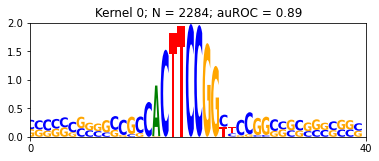

In [80]:
fig, axes = plt.subplots(4,4, figsize=(20,8), tight_layout=True)
for plot_i, i in enumerate(np.argsort(list(AUCs.values()))[::-1]):
    n = df[df["kernel"] == i].shape[0]
    auc = AUCs[i]
    ax = axes.flatten()[plot_i]
    ppm = logomaker.alignment_to_matrix(df[df["kernel"] == i].seq, to_type="counts")
    ppm = ppm[["A", "C", "G", "T"]]
    ppm = ppm.div(ppm.sum(axis=1), axis=0)
    logomaker.Logo(ppm.applymap(get_information_content), ax=ax)
    ax.set_ylim([0,2])
    ax.set_xlim([0, w+8])
    ax.set_xticks([0, w+8])
    ax.set_title("Kernel {0}; N = {1}; auROC = {2:.2f}".format(i, n, auc))
for i in range(n_motifs, 16):
    fig.delaxes(axes.flatten()[i])
plt.savefig(output_dir + "/logos.png")